In [ ]:
# Imports and setup
import os
import pandas as pd
import numpy as np
import pm4py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances
import networkx as nx

XES_PATH = r"BPI2017Denied(3).xes"
OUTPUT_DIR = "outputs_task_similarity_nb"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# Load XES (with fallbacks)
last_err = None
log = None
for variant in (None, 'iterparse', 'etree'):
    try:
        if variant is None:
            log = pm4py.read_xes(XES_PATH)
        else:
            log = pm4py.read_xes(XES_PATH, variant=variant)
        print(f"Loaded XES with variant: {variant or 'default'}")
        break
    except Exception as e:
        last_err = e
        print(f"Failed with variant {variant}: {e}")
        log = None
if log is None:
    raise RuntimeError(f"Failed to import XES: {last_err}")

d:\OneDrive - TU Eindhoven\JADS\Semester C\Process Mining\.venv\Lib\site-packages\pm4py\utils.py:800: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
d:\OneDrive - TU Eindhoven\JADS\Semester C\Process Mining\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 3093/3093 [00:09<00:00, 342.71it/s]


Loaded XES with variant: default


In [ ]:
# Convert to DataFrame, build matrix
from pm4py.objects.conversion.log import converter as log_converter

df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
col_map = {
    'case:concept:name': 'case_id',
    'concept:name': 'activity',
    'org:resource': 'resource',
    'time:timestamp': 'timestamp'
}
for old, new in col_map.items():
    if old in df.columns:
        df = df.rename(columns={old: new})

req = ['case_id', 'activity', 'resource']
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

use_cols = ['case_id', 'activity', 'resource', 'timestamp'] if 'timestamp' in df.columns else ['case_id', 'activity', 'resource']
df = df[use_cols].dropna(subset=['case_id','activity','resource']).copy()

counts = (
    df.groupby(['resource','activity','case_id'])
      .size()
      .rename('count')
      .reset_index()
)
mean_per_case = (
    counts.groupby(['resource','activity'])['count']
          .mean()
          .rename('mean_per_case')
          .reset_index()
)
matrix = mean_per_case.pivot(index='resource', columns='activity', values='mean_per_case').fillna(0.0)

matrix.shape

(134, 54)

In [6]:
matrix

activity,A-Accepted,A-Complete,A-Concept,A-Create-Application,A-Denied,A-Incomplete,A-Submitted,A-Validating,O-Cancelled,O-Create-Offer,...,W-Shortened-completion-start,W-Shortened-completion-suspend,W-Validate-application-ate-abort,W-Validate-application-complete,W-Validate-application-resume,W-Validate-application-schedule,W-Validate-application-start,W-Validate-application-suspend,end,start
resource,,,,,,,,,,,,,,,,,,,,,
User_1,0.0,0.0,1.0,1.0,0.0,0.000000,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,5.769231,0.0,1.0
User_10,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,1.0,1.0,1.068966,...,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.0,1.0
User_100,1.0,1.0,1.0,1.0,1.0,1.119048,0.0,1.0,0.0,1.000000,...,0.0,0.0,1.126506,1.000000,1.655172,1.0,1.000000,1.675676,1.0,1.0
User_101,0.0,0.0,0.0,0.0,1.0,1.105263,0.0,1.0,0.0,0.000000,...,0.0,0.0,1.118421,0.000000,1.600000,1.0,1.000000,1.375000,1.0,0.0
User_102,0.0,0.0,0.0,0.0,1.0,1.413793,0.0,1.0,0.0,0.000000,...,0.0,0.0,1.189655,1.357143,1.851485,1.0,1.000000,1.730769,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_93,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,1.0,0.0,1.000000,...,0.0,0.0,1.000000,1.032258,1.689266,1.0,1.000000,1.740260,1.0,1.0
User_95,1.0,1.0,1.0,1.0,1.0,1.147059,0.0,1.0,0.0,1.000000,...,0.0,0.0,1.000000,1.130000,1.417671,1.0,1.000000,1.181818,1.0,1.0
User_96,1.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.066667,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0


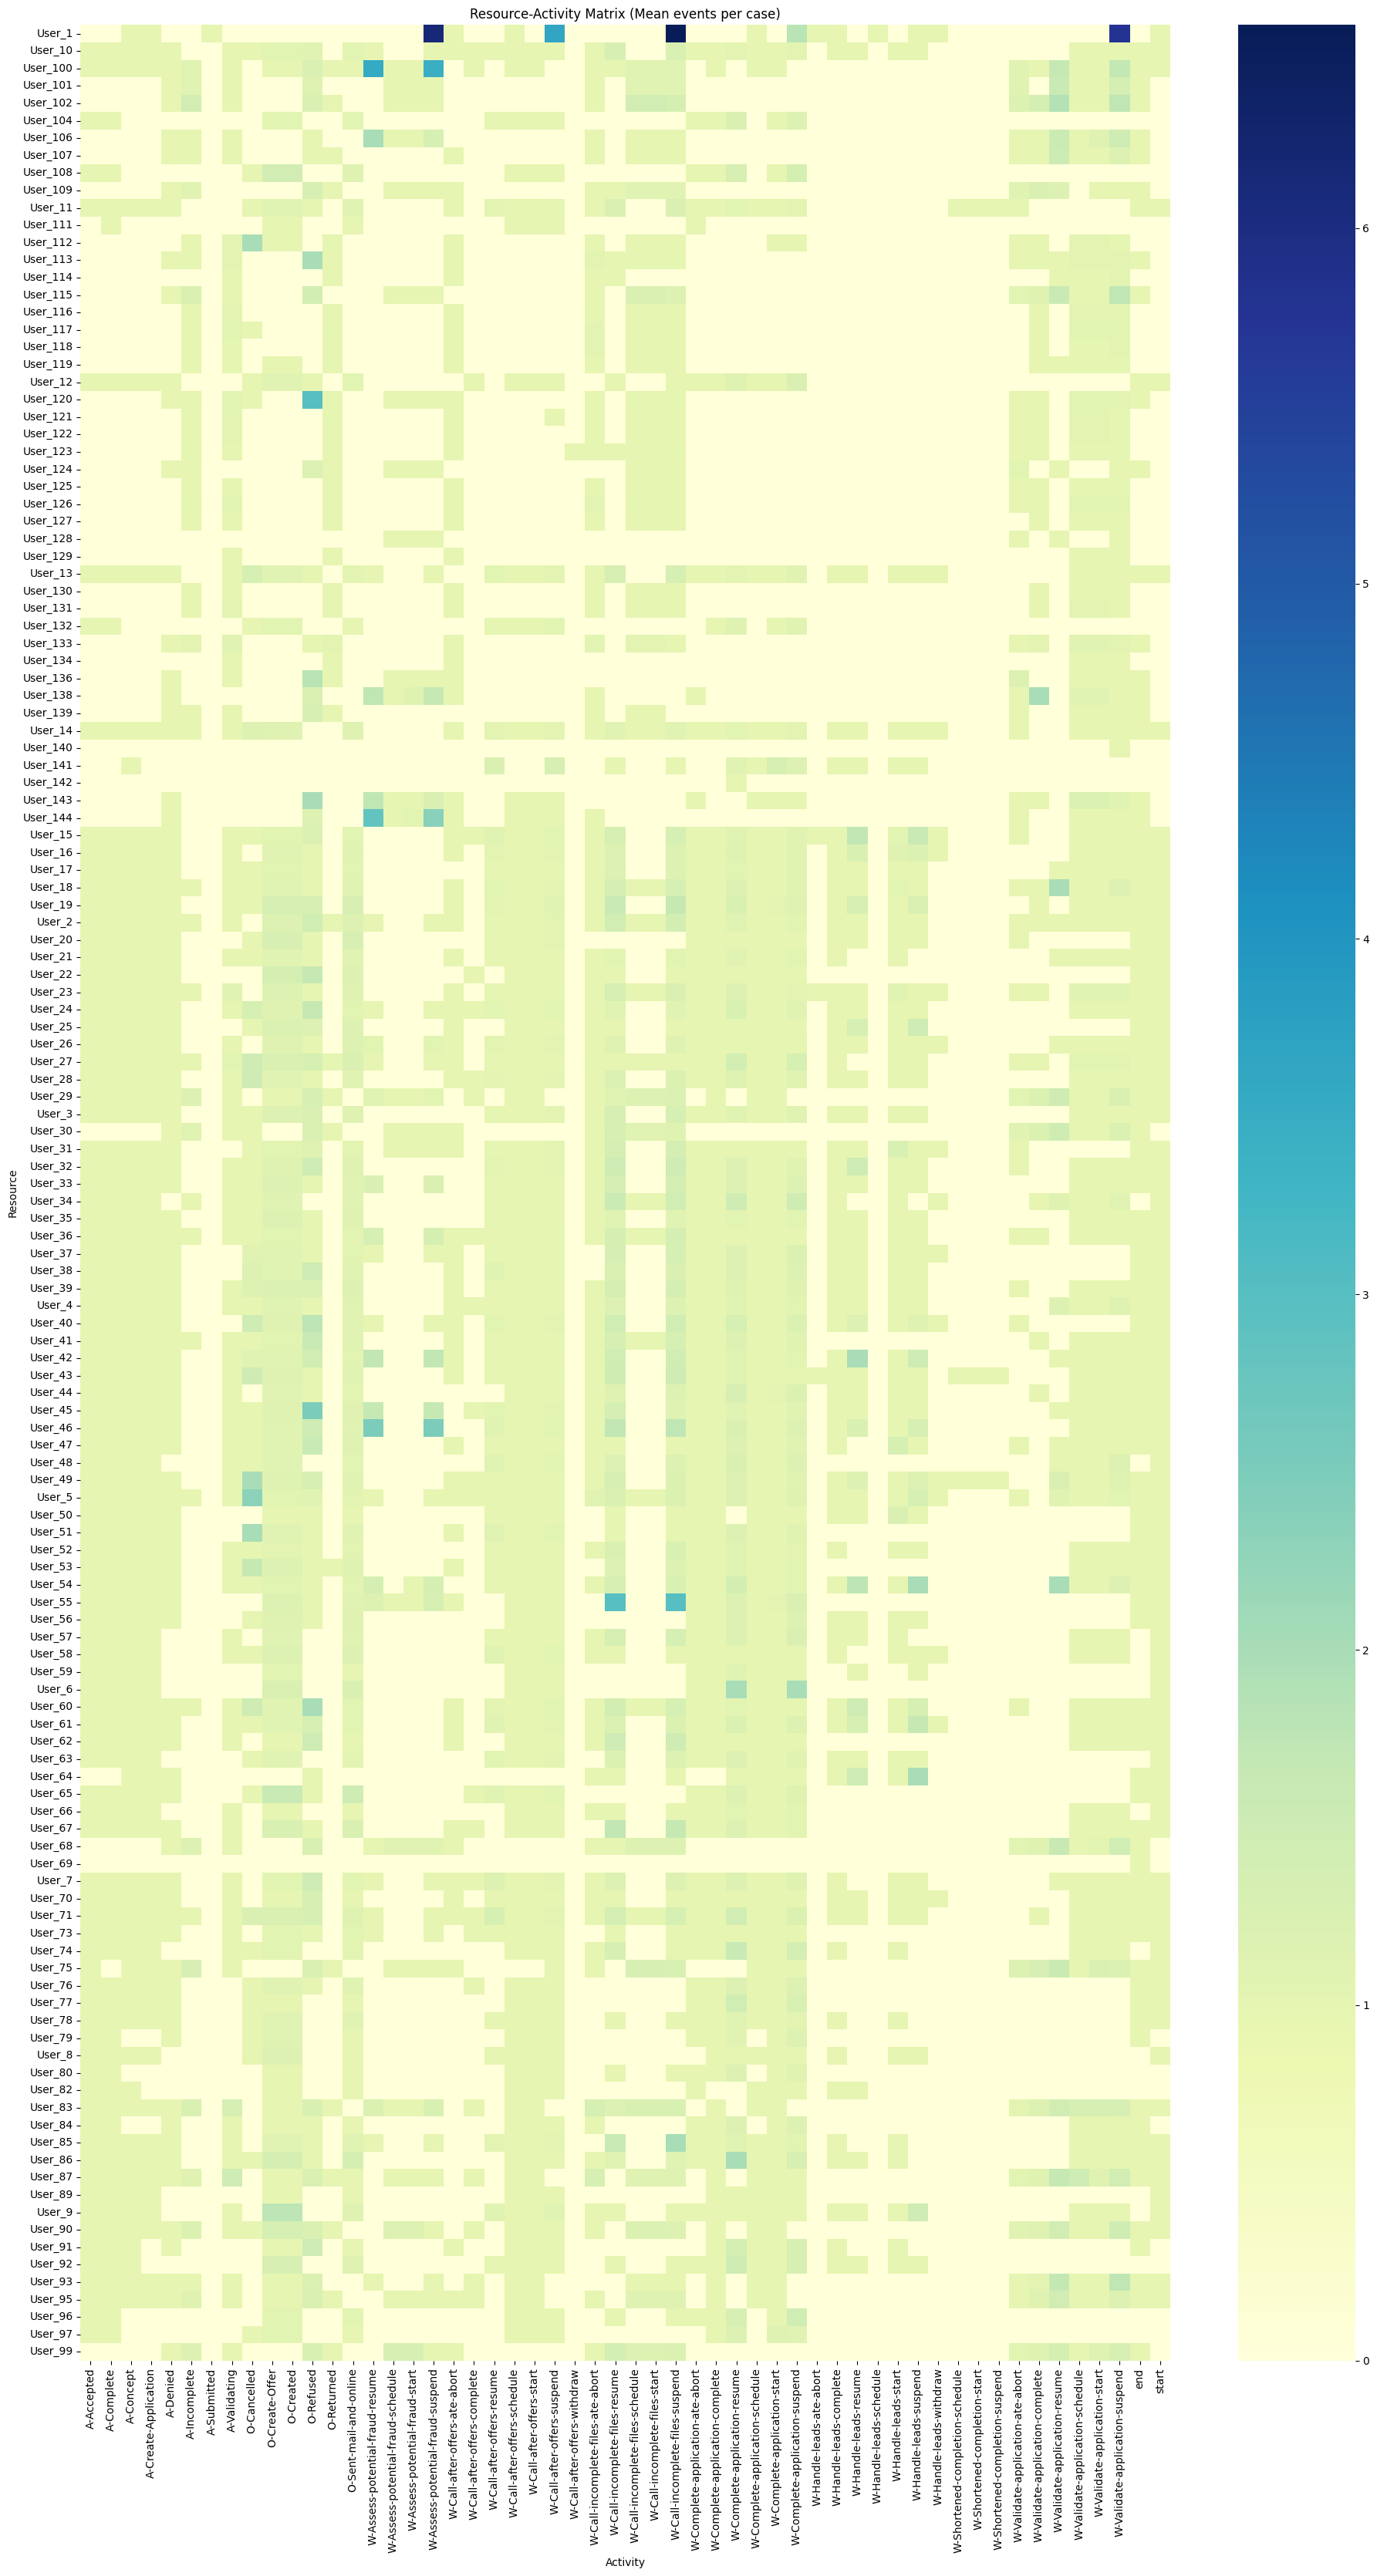

'outputs_task_similarity_nb\\resource_activity_mean_per_case.csv'

In [7]:
# Visualize and export matrix
matrix_sorted = matrix.sort_index(axis=0).sort_index(axis=1)
matrix_csv = os.path.join(OUTPUT_DIR, 'resource_activity_mean_per_case.csv')
matrix_sorted.to_csv(matrix_csv)

plt.figure(figsize=(max(8, matrix_sorted.shape[1]*0.35), max(6, matrix_sorted.shape[0]*0.25)))
sns.heatmap(matrix_sorted, cmap='YlGnBu')
plt.title('Resource-Activity Matrix (Mean events per case)')
plt.xlabel('Activity')
plt.ylabel('Resource')
plt.tight_layout()
plt.show()

matrix_csv

In [ ]:
# Compute pair-wise weights with extended metrics and preferences
# Options for metric: 'cosine_similarity', 'cosine_distance', 'euclidean', 'minkowski', 'hamming', 'pearson'
metric = 'cosine_distance'
# Parameter for Minkowski (only used if metric == 'minkowski')
minkowski_p = 2

if matrix.shape[0] == 0:
    raise ValueError('Empty resource-activity matrix.')

metric_l = metric.lower()
if metric_l == 'cosine_similarity':
    weights = pd.DataFrame(cosine_similarity(matrix.values), index=matrix.index, columns=matrix.index)
elif metric_l in ('cosine_distance', 'cosine'):
    weights = pd.DataFrame(1.0 - cosine_similarity(matrix.values), index=matrix.index, columns=matrix.index)
elif metric_l == 'euclidean':
    weights = pd.DataFrame(euclidean_distances(matrix.values), index=matrix.index, columns=matrix.index)
elif metric_l == 'minkowski':
    weights = pd.DataFrame(pairwise_distances(matrix.values, metric='minkowski', p=minkowski_p), index=matrix.index, columns=matrix.index)
elif metric_l == 'hamming':
    weights = pd.DataFrame(pairwise_distances(matrix.values, metric='hamming'), index=matrix.index, columns=matrix.index)
elif metric_l == 'pearson':
    corr = np.corrcoef(matrix.values)
    weights = pd.DataFrame(corr, index=matrix.index, columns=matrix.index).fillna(0.0)
else:
    raise ValueError('Unsupported metric')

weights.iloc[:5, :5]


resource,User_1,User_10,User_100,User_101,User_102
resource,,,,,
User_1,3.330669e-16,5.484928e-01,5.440801e-01,0.609269,0.611502
User_10,5.484928e-01,3.330669e-16,3.351853e-01,0.613412,0.648527
User_100,5.440801e-01,3.351853e-01,5.551115e-16,0.337339,0.323791
User_101,6.092690e-01,6.134118e-01,3.373394e-01,0.000000,0.055188
User_102,6.115017e-01,6.485270e-01,3.237908e-01,0.055188,0.000000


Nodes: 134, Edges: 3006


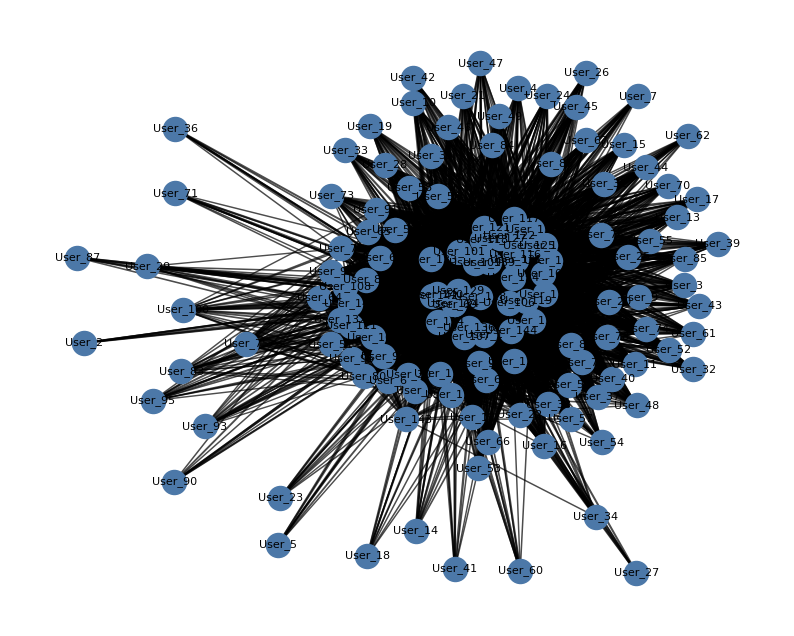

In [ ]:
# Measure preference: 'similarity' (higher is stronger) or 'distance' (lower is stronger)
measure_preference = 'similarity'

# Build and visualize network using measure preference and threshold_value
use_similarity = (measure_preference == 'similarity')

G = nx.Graph()
for r in weights.index:
    G.add_node(r)

# Threshold to filter weak connections (>= for similarity, <= for distance)
threshold_value = 0.6

nodes = list(weights.index)
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        u, v = nodes[i], nodes[j]
        w = float(weights.loc[u, v])
        if use_similarity:
            if w >= threshold_value:
                G.add_edge(u, v, weight=w)
        else:
            if w <= threshold_value:
                G.add_edge(u, v, weight=w)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)
edge_w = [1 + 2 * max(0.0, (d.get('weight', 1.0) - threshold_value)) if use_similarity else 1 for _,_,d in G.edges(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='#4C78A8')
nx.draw_networkx_edges(G, pos, width=edge_w, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis('off')
plt.show()